# GAPF for the UCI HAR Data Set

In [9]:
import torch
import torch.utils.data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

In [2]:
X_train = pd.read_csv("./data/X_train.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv("./data/y_train.txt", delim_whitespace=True, header=None)
s_train = pd.read_csv("./data/subject_train.txt", header=None)

X_test = pd.read_csv("./data/X_test.txt", delim_whitespace=True, header=None)
y_test = pd.read_csv("./data/y_test.txt", delim_whitespace=True, header=None)
s_test = pd.read_csv("./data/subject_test.txt", header=None)

In [3]:
# Change s index to be 0-29 instead of 1-30
s_train[0] = s_train[0] - 1
s_test[0] = s_test[0] - 1


# Change y index to be 0-5 instead of 1-6
y_train[0] = y_train[0] - 1
y_test[0] = y_test[0] - 1

## Create Tensors

In [4]:
# Tensor for the training data and sensitive attribute
X_tensor = torch.tensor(X_train.values, device=device).double()
s_tensor = torch.tensor(s_train.values, device=device).double()
y_tensor = torch.tensor(y_train.values, device=device).double()

# Tensor for the testing data and sensitive attribute
X_tensor_test = torch.tensor(X_test.values, device=device).double()
s_tensor_test = torch.tensor(s_test.values, device=device).double()
y_tensor_test = torch.tensor(y_test.values, device=device).double()

# Append 100D noise to the training tensor for the generator training
noise = torch.randn([X_train.shape[0], 100], device=device).double()
noised_tensor = torch.cat((X_tensor, noise), 1)


# Append 100D noise to the testing tensor for the generator training
noise_test = torch.randn([X_test.shape[0], 100], device=device).double()
noised_tensor_test = torch.cat((X_tensor_test, noise_test), 1)

## Create Models

In [5]:
model_gen = torch.nn.Sequential(
          # Layer 1 - 661 -> 512
          torch.nn.Linear(661, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(512, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 3 - 512 -> 512
          torch.nn.Linear(512, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Output
          torch.nn.Linear(512, 561),
        ).to(device)

model_adv = torch.nn.Sequential(
          # Layer 1 - 561 -> 512
          torch.nn.Linear(561, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(512, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 3 - 512 -> 256
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 30
          torch.nn.Linear(128, 30),
        ).to(device)

model_class = torch.nn.Sequential(
          # Layer 1 - 561 -> 512
          torch.nn.Linear(561, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(512, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 3 - 512 -> 256
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 6
          torch.nn.Linear(128, 6),
        ).to(device)

In [6]:
optim_gen = torch.optim.Adam(model_gen.parameters())
loss_gen = torch.nn.CrossEntropyLoss()

optim_adv = torch.optim.Adam(model_adv.parameters())
loss_adv = torch.nn.CrossEntropyLoss()

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

## Train Adversarially

In [8]:
NUM_EPOCHS_GEN = 5
NUM_EPOCHS_ADV = 1
NUM_TOTAL_ITER = 15
DISTORTION_WEIGHT = 0.1
D = 3

train_loader = torch.utils.data.DataLoader(
    torch.cat((noised_tensor, s_tensor), 1), 
    batch_size=512, 
    shuffle=True)

loss_by_epoch_g = []
loss_by_epoch_a = []

for epoch in range(NUM_TOTAL_ITER):
  print("Epoch: ", epoch)
  for j in range(NUM_EPOCHS_GEN):
    total_loss_g = 0
    total_loss_d = 0
    num = 0
    for batch in train_loader:
      x, s = batch[:, 0:-1], batch[:, -1].long()
      x_hat = model_gen(x.float())
      adv_pred = model_adv(x_hat.float())

    
      loss_g = -loss_adv(adv_pred, s)
      dist_loss = torch.dist(x_hat, x[:, 0:561].float()) * DISTORTION_WEIGHT
      if dist_loss < D:
        dist_loss = 0
      total_loss_d += dist_loss
      
      loss_g += dist_loss

      num += 1
      total_loss_g += loss_g

      optim_gen.zero_grad()
      loss_g.backward()
      optim_gen.step()
    epch_loss = (total_loss_g/num).item()
    loss_by_epoch_g.append(epch_loss)
    print("Gen loss: ", epch_loss)
    
  for j in range(NUM_EPOCHS_ADV):
    total_loss_a = 0
    num = 0
    for batch in train_loader:
      x, s = batch[:, 0:-1], batch[:, -1].long()
      
      x_hat = model_gen(x.float())
      
      s_pred = model_adv(x_hat)

      loss_a = loss_adv(s_pred, s)
      num += 1
      total_loss_a += loss_a
      
      optim_adv.zero_grad()
      loss_a.backward(retain_graph=True)
      optim_adv.step()
    epch_loss = (total_loss_a/num).item()
    loss_by_epoch_a.append(epch_loss)
    print("Adv loss: ", (total_loss_a/num).item())
  print("\n")  

Epoch:  0
Gen loss:  2.762157678604126
Gen loss:  2.51141357421875
Gen loss:  2.312122344970703
Gen loss:  2.240082263946533
Gen loss:  2.0898985862731934
Adv loss:  2.5481252670288086


Epoch:  1
Gen loss:  2.422478675842285
Gen loss:  2.2482078075408936
Gen loss:  1.9477498531341553
Gen loss:  1.7452876567840576
Gen loss:  1.4330785274505615
Adv loss:  2.6010947227478027


Epoch:  2
Gen loss:  2.024982213973999
Gen loss:  1.8570753335952759
Gen loss:  1.7741703987121582
Gen loss:  1.3622417449951172
Gen loss:  1.2412155866622925
Adv loss:  2.5633740425109863


Epoch:  3
Gen loss:  1.9792178869247437
Gen loss:  1.5203893184661865
Gen loss:  1.388076663017273
Gen loss:  1.1743031740188599
Gen loss:  1.1110395193099976
Adv loss:  2.5885751247406006


Epoch:  4
Gen loss:  1.853046178817749
Gen loss:  1.27159583568573
Gen loss:  1.2359496355056763
Gen loss:  1.122801661491394
Gen loss:  1.1580946445465088
Adv loss:  2.409184694290161


Epoch:  5
Gen loss:  1.6467570066452026
Gen loss:  1.

[Text(0, 0.5, 'Generator Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Generator Loss Curve W/ D=7')]

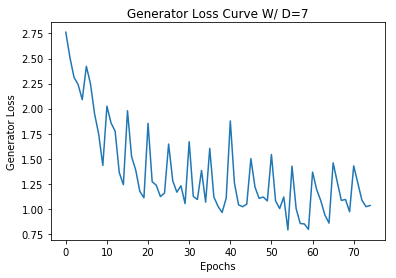

In [13]:
ax = plt.axes()
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_GEN), loss_by_epoch_g)
ax.set(xlabel="Epochs", ylabel="Generator Loss", Title="Generator Loss Curve W/ D=7")

[Text(0, 0.5, 'Adversary Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Adversary Loss Curve')]

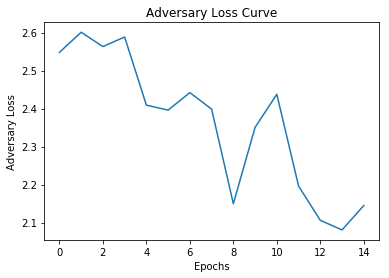

In [14]:
ax = plt.axes()
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_ADV), loss_by_epoch_a)
ax.set(xlabel="Epochs", ylabel="Adversary Loss", Title="Adversary Loss Curve")

# Testing
## Test Adversary before and after decorrelation

In [15]:
out_class = model_adv(X_tensor.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.6353373231773667


In [16]:
gen_noised = model_gen(noised_tensor.float())

out_class = model_adv(gen_noised.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.4771490750816104


## Test Classifier Before and After Decorrelation

### Before

In [ ]:
class_loader = torch.utils.data.DataLoader(
    torch.cat((X_tensor, y_tensor), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
  loss_avg = 0
  num = 0
  for batch in class_loader:
    x, y = batch[:, 0:-1], batch[:, -1]
    y_pred = model_class(x.float())

    loss = loss_class(y_pred, y.long())
    loss_avg += loss
    num += 1

    optim_class.zero_grad()
    loss.backward()
    optim_class.step()
  print("loss: ", (loss_avg/num).item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loss:  tensor(0.6459, device='cuda:0')
loss:  tensor(0.1994, device='cuda:0')
loss:  tensor(0.1168, device='cuda:0')
loss:  tensor(0.0851, device='cuda:0')
loss:  tensor(0.0632, device='cuda:0')
loss:  tensor(0.0522, device='cuda:0')
loss:  tensor(0.0491, device='cuda:0')
loss:  tensor(0.0460, device='cuda:0')
loss:  tensor(0.0402, device='cuda:0')
loss:  tensor(0.0358, device='cuda:0')
loss:  tensor(0.0389, device='cuda:0')
loss:  tensor(0.0344, device='cuda:0')
loss:  tensor(0.0339, device='cuda:0')
loss:  tensor(0.0299, device='cuda:0')
loss:  tensor(0.0296, device='cuda:0')
loss:  tensor(0.0241, device='cuda:0')
loss:  tensor(0.0247, device='cuda:0')
loss:  tensor(0.0245, device='cuda:0')
loss:  tensor(0.0221, device='cuda:0')
loss:  tensor(0.0152, device='cuda:0')


In [ ]:
out_class = model_class(X_tensor_test.float())
v, i = torch.max(out_class, 1)
print((y_tensor_test.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor_test.shape[0])

0.9589412962334578


### After

In [ ]:
model_class = torch.nn.Sequential(
          # Layer 1 - 561 -> 512
          torch.nn.Linear(561, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(512, 512),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(512),
          # Layer 3 - 512 -> 256
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 6
          torch.nn.Linear(128, 6),
        ).to(device)

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

gen_noised = model_gen(noised_tensor.float())

class_loader = torch.utils.data.DataLoader(
    torch.cat((gen_noised.float(), y_tensor.float()), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
  loss_avg = 0
  num = 0
  for batch in class_loader:
    x, y = batch[:, 0:-1], batch[:, -1]
    y_pred = model_class(x.float())

    loss = loss_class(y_pred, y.long())
    loss_avg += loss
    num += 1

    optim_class.zero_grad()
    loss.backward(retain_graph=True)
    optim_class.step()
  print("loss: ", (loss_avg/num).item())

loss:  0.6359238624572754
loss:  0.22694246470928192
loss:  0.13943733274936676
loss:  0.1030813604593277
loss:  0.08952376246452332
loss:  0.08020778000354767
loss:  0.06571952998638153
loss:  0.06776061654090881
loss:  0.05831295996904373
loss:  0.0489499606192112
loss:  0.047430653125047684
loss:  0.04686059057712555
loss:  0.04153882712125778
loss:  0.03858698159456253
loss:  0.04043963924050331
loss:  0.05129847303032875
loss:  0.053298063576221466
loss:  0.03892166167497635
loss:  0.03216115012764931
loss:  0.027386115863919258


In [ ]:
out_class = model_class(X_tensor_test.float())
v, i = torch.max(out_class, 1)
print((y_tensor_test.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor_test.shape[0])

0.9477434679334917
